# Clean up for your vacation images

In [1]:
# Define global variables, are explained below

IMAGES = './images/' # path to the images
IMAGES_PREPROCESSED = './preprocessed/' # not used at the moment
IMAGES_PROCESSED = './processed/' # output destination
HASH_DIM = (8, 8)

In [2]:
import glob
import os
import shutil

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as sts
from sklearn.linear_model import LogisticRegression

import spring_cleaning as sc # outsourced code

# Pipeline

In [3]:
# Load images and meta data

dict_files = sc.read_files(path=IMAGES, ext='jpg')

df = pd.DataFrame(dict_files, columns=['file', 'creation_date'])
df['creation_date'] = pd.to_numeric(df['creation_date'], downcast='integer')

# For ranking of images, we need some intrinsic measure for consecutiveness
# 'Creation Date' of images is a good measure
# 'File Name' as well, if pictures are taken from one and the same camera

# alternatively, sort by Filename: df.sort_values(by=['File'])
df = df.sort_values(by=['creation_date'])
df['timediff_value'] = df['creation_date'].diff(-1).abs()

# Load images
df['gray_images'] = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='gray')) 
                                            for cur_file in df['file'].values]

df['hsv_images'] = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='hsv')) 
                                            for cur_file in df['file'].values]

df['rgb_images'] = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='rgb')) 
                                            for cur_file in df['file'].values]

df[[c for c in df.columns if not c.endswith('_images')]].head()

,file,creation_date,timediff_value
23,ar_1.JPG,1487935036,0.0
22,ar_0.JPG,1487935036,16.0
25,as_1.JPG,1487935052,0.0
24,as_0.JPG,1487935052,10.0
26,at_0.JPG,1487935062,2.0


In [4]:
# Assign labels
df = df.assign(target = df['file'].str.split(n=0, pat='_', expand=True).loc[:, 0])
df['target'], _ = pd.factorize(df['target'])
df['target'] = df['target'] + 1
n_img = len(df['target'].unique())

# perfect performance output 
sc.calculate_performance(df['target'], df['target'], n_img)

(20, 20, 20, 1.0)

In [5]:
# Rank by time
# useful, if sequences of images are shot

df['timediff_rank'] = sc.timelag_ranker(df['timediff_value'])

# Rank by axis-ratio change
df['axisratio_value'] = df['gray_images'].apply(lambda x: 
                                        sc.calculate_axis_ratio(x)).diff(-1).fillna(0)
df['axisratio_rank'] = sc.img_shape_ranker(df['axisratio_value'])

In [6]:
# Rank by image hash

# method 1: mean value
# method 2: logistic regression

# Using limit estimates from method 1
df['hash_value'] = sc.compare_hashes_adv(df['gray_images'], return_hash_only=True)
df['hash_rank'] = sc.hash_ranker(df['hash_value'], HASH_DIM)

df['hash_adv_value'] = sc.compare_hashes_adv(df['gray_images'])
df['hash_adv_rank'] = sc.hash_ranker(df['hash_adv_value'], HASH_DIM, 0.925)

# Using limit estimates from method 2
df['hash_rank_2'] = sc.hash_ranker(df['hash_value'], HASH_DIM, limit=0.781)
df['hash_adv_rank_2'] = sc.hash_ranker(df['hash_adv_value'], HASH_DIM, 0.84)

In [7]:
# Further hashing algorithms from opencv

# Using limit estimates from method 1
df['avg_hash_value'] = sc.hash_image(df['rgb_images'], 'avg_hash')
df['avg_hash_rank'] = sc.hash_ranker2(df['avg_hash_value'], 0.89)

df['block_hash_value'] = sc.hash_image(df['rgb_images'], 'block_hash')
df['block_hash_rank'] = sc.hash_ranker2(df['block_hash_value'], 0.94)

df['phash_value'] = sc.hash_image(df['rgb_images'], 'phash')
df['phash_rank'] = sc.hash_ranker2(df['phash_value'], 0.84)

df['marr_hildreth_hash_value'] = sc.hash_image(df['rgb_images'], 'marr_hildreth_hash')
df['marr_hildreth_hash_rank'] = sc.hash_ranker2(df['marr_hildreth_hash_value'], 0.86)

df['radial_variance_hash_value'] = sc.hash_image(df['rgb_images'], 'radial_variance_hash')
df['radial_variance_hash_rank'] = sc.hash_ranker2(df['radial_variance_hash_value'], 0.66)

# Using limit estimates from method 2
df['avg_hash_rank_2'] = sc.hash_ranker2(df['avg_hash_value'], 0.82)
df['block_hash_rank_2'] = sc.hash_ranker2(df['block_hash_value'], 0.87)
df['phash_rank_2'] = sc.hash_ranker2(df['phash_value'], 0.73)
df['marr_hildreth_hash_rank_2'] = sc.hash_ranker2(df['marr_hildreth_hash_value'], 0.71)
df['radial_variance_hash_rank_2'] = sc.hash_ranker2(df['radial_variance_hash_value'], 0.66)

In [8]:
# Rank by correlation of image histograms

# Using limit estimates from method 1
df['correl_corr'] = sc.calc_correlations(df['hsv_images'], 'correl')
df['correl_rank'] = sc.corr_ranker(df['correl_corr'])

df['bhattacharyya_corr'] = sc.calc_correlations(df['hsv_images'], 'bhattacharyya')
df['bhattacharyya_rank'] = sc.corr_ranker(df['bhattacharyya_corr'])

# Using limit estimates from method 2
corr_limits={'bhattacharyya': 0.46, 'correl': 0.47}
df['correl_rank_2'] = sc.corr_ranker(df['correl_corr'], limits=corr_limits)
df['bhattacharyya_rank_2'] = sc.corr_ranker(df['bhattacharyya_corr'], limits=corr_limits)

In [9]:
# Create ranks from ensemble of methods

voting_col = [col for col in df.columns if col in ('hash_rank', 'hash_adv_rank',
                                                  'correl_rank', 'bhattacharyya_rank')
              and (not col.endswith('voting_rank')) 
              and (not col.endswith('voting_rank_2'))]
voting_col_2 = [col+'_2' for col in voting_col]

df['voting_diff'] = df[voting_col].diff(-1).fillna(-1).apply(
    lambda x: 1 + np.mean(x), axis=1)
df['voting_diff_2'] = df[voting_col_2].diff(-1).fillna(-1).apply(
    lambda x: 1 + np.mean(x), axis=1)

df['voting_rank'] = sc.vote_ranker(df['voting_diff'])
df['voting_rank_2'] = sc.vote_ranker(df['voting_diff_2'])

# Performance summary - Ranker

In [10]:
evals = {col: sc.calculate_performance(df['target'], df[col], n_img) 
             for col in df.columns if ('rank' or 'target') in col
}
df_eval = pd.DataFrame.from_dict(evals, orient='index', 
            columns=['groups_found', 'groups_unique', 'groups_true', 'reduction']
            ).sort_values(by=['reduction'])

df_eval

,groups_found,groups_unique,groups_true,reduction
axisratio_rank,0,5,20,0.0000
voting_rank_2,13,16,20,0.5200
avg_hash_rank_2,13,17,20,0.5525
hash_adv_rank_2,14,17,20,0.5950
hash_rank_2,14,18,20,0.6300
correl_rank_2,17,20,20,0.8500
block_hash_rank_2,18,19,20,0.8550
bhattacharyya_rank_2,18,20,20,0.9000
phash_rank_2,19,20,20,0.9500
marr_hildreth_hash_rank_2,20,21,20,1.0500


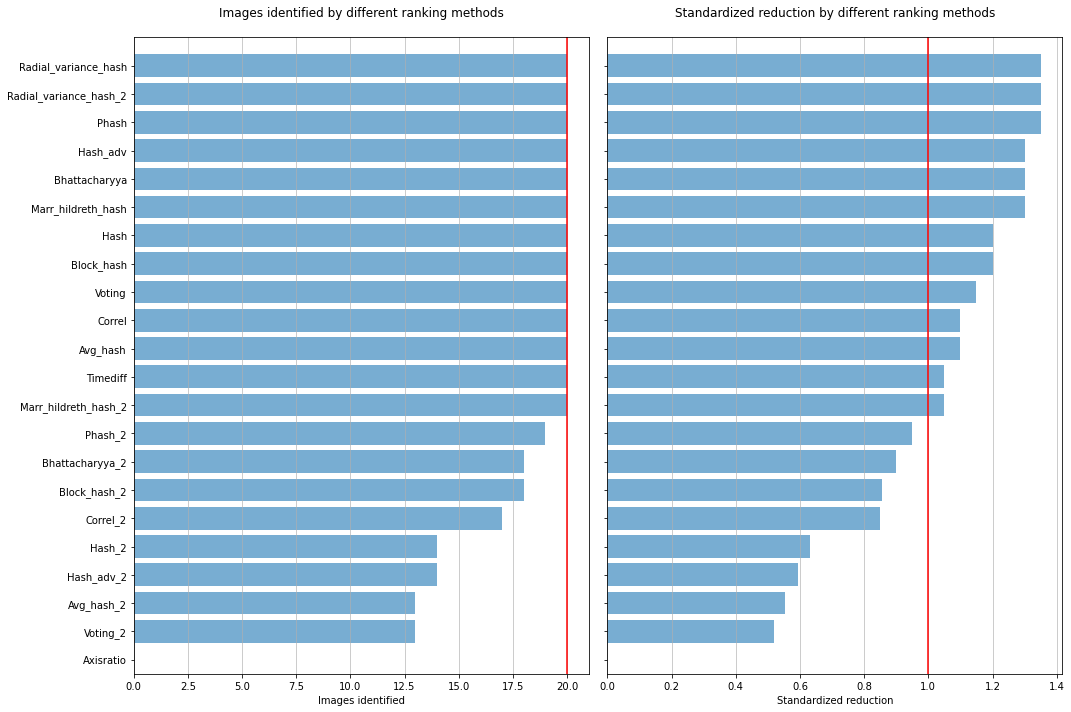

In [11]:
# for our example data, the timediff_rank and correl_rank seems to provide the best results
# the conservative limits provide better results

sc.plot_summary(df_eval)

# Identify the best images: high-pass filtering

In [12]:
# for the time being, the best image refers to having most structure

df['magnitude_spectrum_f'] = df['gray_images'].apply(lambda x: sc.high_pass_filter(x))

# Apply results

In [14]:
# Finally, copy the images into ready-to-go directory, that's it!

sc.copy_images(df, (IMAGES, IMAGES_PROCESSED), 'timediff_rank', 'magnitude_spectrum_f')